In [1]:
from config import api_key
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("movie_data.csv", nrows=500)
df.head()

,Movie,Month,Day,Release Year,Budget ($m),Domestic Gross ($m),Worldwide Gross ($m),Foreign Gross ($m)
0,Star Wars Ep. VII: The Force Awakens,Dec,18,2015,306.0,936.662225,2058.662225,1122.000000
1,Jurassic World,Jun,12,2015,215.0,652.198010,1670.328025,1018.130015
2,The Avengers,May,4,2012,225.0,623.279547,1519.479547,896.200000
3,Furious 7,Apr,3,2015,190.0,351.032910,1514.019071,1162.986161
4,Avengers: Age of Ultron,May,1,2015,250.0,459.005868,1404.705868,945.700000


In [3]:
base = f"http://www.omdbapi.com/?apikey={api_key}&r=json&t="
urls = [(base + row) for row in df["Movie"]]

In [4]:
responses = [requests.get(url).json() for url in urls]

In [5]:
len(responses)

500

In [6]:
rows_to_remove = []
for response in responses:
    if response["Response"] == "False":
        rows_to_remove.append(responses.index(response))
        responses.remove(response)

In [7]:
print(rows_to_remove)
print(len(responses))
# 475 valid instances out of 500 to analyze.

[0, 4, 21, 30, 88, 122, 128, 145, 147, 156, 197, 247, 248, 249, 258, 264, 283, 290, 292, 326, 340, 366, 405, 422, 437]
475


In [8]:
# Remove the rows with no responses.
df = df.drop(rows_to_remove).reset_index()
del df["index"]
df.head()

,Movie,Month,Day,Release Year,Budget ($m),Domestic Gross ($m),Worldwide Gross ($m),Foreign Gross ($m)
0,Jurassic World,Jun,12,2015,215.0,652.198010,1670.328025,1018.130015
1,The Avengers,May,4,2012,225.0,623.279547,1519.479547,896.200000
2,Furious 7,Apr,3,2015,190.0,351.032910,1514.019071,1162.986161
3,Harry Potter and the Deathly Hallows: Part II,Jul,15,2011,125.0,381.011219,1341.511219,960.500000
4,Frozen,Nov,22,2013,150.0,400.738009,1274.234980,873.496971


## Audience rating vs. critic rating vs. worldwide box office

In [9]:
rating_df = df[["Movie", "Worldwide Gross ($m)"]].copy()
rating_df["IMDb Rating"] = [responses[_]["imdbRating"] for _ in range(len(responses))]
rating_df["Metascore"] = [responses[_]["Metascore"] for _ in range(len(responses))]

In [10]:
# The ratings are strings when imported.
rating_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 475 entries, 0 to 474
Data columns (total 4 columns):
Movie                   475 non-null object
Worldwide Gross ($m)    475 non-null float64
IMDb Rating             475 non-null object
Metascore               475 non-null object
dtypes: float64(1), object(3)
memory usage: 14.9+ KB


In [11]:
# Also, there are missing values in ratings.
rating_df["Metascore"].value_counts()

57     14
56     13
39     13
52     13
55     13
59     13
58     12
66     12
51     12
53     12
60     12
N/A    11
40     11
65     10
68     10
75     10
74     10
41     10
72     10
34      9
62      9
37      8
50      8
44      8
63      8
47      8
69      8
67      7
45      7
64      7
       ..
78      4
73      3
84      3
70      3
27      3
83      3
90      3
88      3
31      3
25      2
80      2
21      2
95      2
24      2
96      2
22      2
86      2
23      2
20      1
26      1
94      1
29      1
82      1
89      1
87      1
19      1
18      1
13      1
92      1
93      1
Name: Metascore, Length: 79, dtype: int64

In [12]:
# Remove missing values.
rating_df = rating_df[rating_df["Metascore"] != "N/A"]
# Change data type to numeric.
rating_df["IMDb Rating"] = rating_df["IMDb Rating"].astype(float)
rating_df["Metascore"] = rating_df["Metascore"].astype(int)
# Normalize the two ratings.
rating_df["IMDb Rating (Normalized)"] = (rating_df["IMDb Rating"] - rating_df["IMDb Rating"].min())/\
                                        (rating_df["IMDb Rating"].max() - rating_df["IMDb Rating"].min())
rating_df["Metascore (Normalized)"] = (rating_df["Metascore"] - rating_df["Metascore"].min())/\
                                        (rating_df["Metascore"].max() - rating_df["Metascore"].min())

In [13]:
rating_df.head()

,Movie,Worldwide Gross ($m),IMDb Rating,Metascore,IMDb Rating (Normalized),Metascore (Normalized)
0,Jurassic World,1670.328025,7.0,59,0.750000,0.554217
1,The Avengers,1519.479547,8.1,69,0.902778,0.674699
2,Furious 7,1514.019071,7.2,67,0.777778,0.650602
3,Harry Potter and the Deathly Hallows: Part II,1341.511219,7.4,66,0.805556,0.638554
4,Frozen,1274.234980,7.5,74,0.819444,0.734940


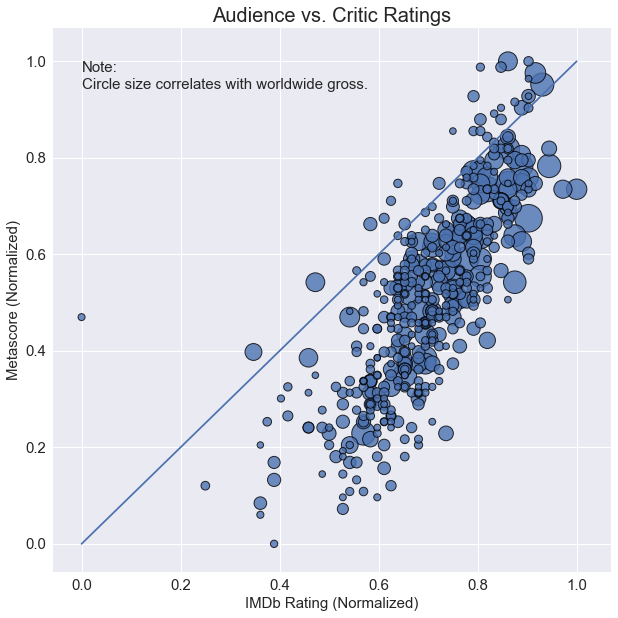

In [14]:
plt.style.use("seaborn")
plt.figure(figsize=(10,10))
plt.scatter(rating_df["IMDb Rating (Normalized)"], rating_df["Metascore (Normalized)"], s=rating_df["Worldwide Gross ($m)"]/2, 
           alpha=.8, lw=1, edgecolors="k")
plt.plot([0,1],[0,1])
plt.title("Audience vs. Critic Ratings", size=20)
plt.xlabel("IMDb Rating (Normalized)", size=15)
plt.ylabel("Metascore (Normalized)", size=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.text(0, 1, "Note:\nCircle size correlates with worldwide gross.", fontsize=15, va="top")
#plt.savefig("Plot1", bbox_inches="tight")
plt.show()

## Genre vs. box office

In [15]:
genre_df = df[["Movie", "Domestic Gross ($m)", "Foreign Gross ($m)"]].copy()
genre_df["Genre Count"] = [len(responses[_]["Genre"].split(", ")) for _ in range(len(responses))]

In [16]:
genre_df["Genre Count"].value_counts()
# Most movies have 3 genres, some 2.

3    353
2     93
1     29
Name: Genre Count, dtype: int64

In [17]:
# Create 3 data frames, add genres, and concatenate them.
genre_df1 = genre_df.copy()
genre_df2 = genre_df.copy()
genre_df3 = genre_df.copy()
genre_df1["Genre"] = [responses[_]["Genre"].split(", ")[0] for _ in range(len(responses))]

In [18]:
for _ in range(len(responses)):
    try:
        genre_df2.loc[_,"Genre"] = responses[_]["Genre"].split(", ")[1]
    except:
        genre_df2.loc[_,"Genre"] = None
genre_df12 = pd.concat([genre_df1, genre_df2])

In [19]:
for _ in range(len(responses)):
    try:
        genre_df3.loc[_,"Genre"] = responses[_]["Genre"].split(", ")[2]
    except:
        genre_df3.loc[_,"Genre"] = None
genre_df123 = pd.concat([genre_df12, genre_df3])

In [20]:
# Remove the rows with no genre.
genre_df123 = genre_df123.dropna(how="any").reset_index()
del genre_df123["index"]
genre_df123.tail()

,Movie,Domestic Gross ($m),Foreign Gross ($m),Genre Count,Genre
1269,J. Edgar,37.306030,47.300000,3,Drama
1270,Priest,29.136626,55.017400,3,Horror
1271,Piranha 3D,25.003155,58.657005,3,Thriller
1272,Edge of Darkness,43.313890,39.498566,3,Mystery
1273,Act of Valor,70.012847,12.484188,3,Drama


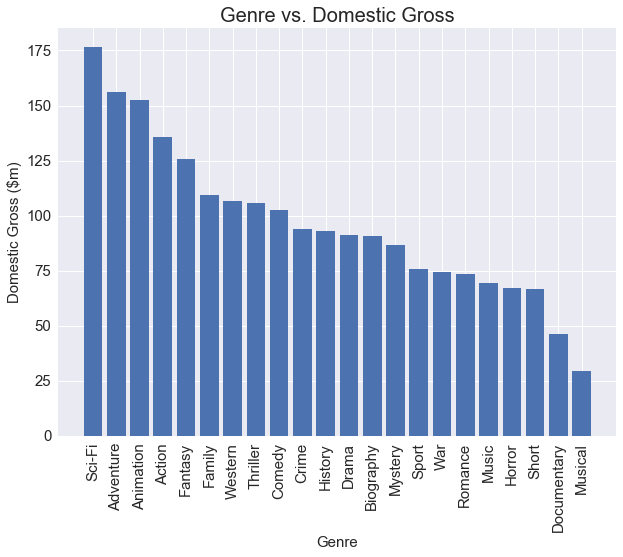

In [21]:
domestic_by_genre = genre_df123.groupby("Genre")["Domestic Gross ($m)"].mean().sort_values(ascending=False)
plt.figure(figsize=(10,7.5))
plt.bar(range(len(domestic_by_genre)), domestic_by_genre, align="center")
plt.title("Genre vs. Domestic Gross", size=20)
plt.xlabel("Genre", size=15)
plt.ylabel("Domestic Gross ($m)", size=15)
plt.xticks(range(len(domestic_by_genre)), domestic_by_genre.index, rotation="vertical", size=15)
plt.yticks(size=15)
#plt.savefig("Plot2.1", bbox_inches="tight")
plt.show()

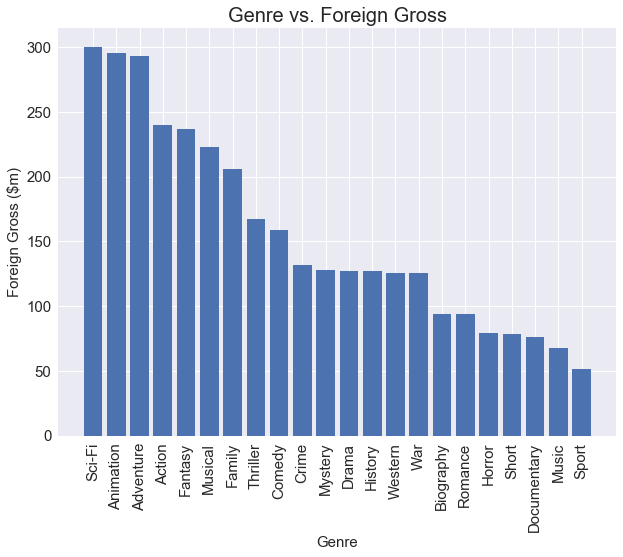

In [22]:
foreign_by_genre = genre_df123.groupby("Genre")["Foreign Gross ($m)"].mean().sort_values(ascending=False)
plt.figure(figsize=(10,7.5))
plt.bar(range(len(foreign_by_genre)), foreign_by_genre, align="center")
plt.title("Genre vs. Foreign Gross", size=20)
plt.xlabel("Genre", size=15)
plt.ylabel("Foreign Gross ($m)", size=15)
plt.xticks(range(len(foreign_by_genre)), foreign_by_genre.index, rotation="vertical", size=15)
plt.yticks(size=15)
#plt.savefig("Plot2.2", bbox_inches="tight")
plt.show()

## Production studio vs. box office

In [28]:
studio_df = df[["Movie", "Domestic Gross ($m)", "Foreign Gross ($m)"]].copy()
for _ in range(len(responses)):
    try:
        studio_df.loc[_,"Production"] = responses[_]["Production"].split(" ")[0].split("/")[0]
    except:
        studio_df.loc[_,"Production"] = None

In [29]:
studio_df["Production"].value_counts()

Warner          77
Universal       62
20th            58
Sony            55
Paramount       50
Walt            40
Lionsgate       25
The             13
Summit           9
Columbia         8
Relativity       7
Focus            6
DreamWorks       5
Fox              5
Screen           4
New              4
N                4
Dreamworks       3
Twentieth        3
TriStar          3
MGM              3
Disney           3
FilmDistrict     3
CBS              2
Open             2
Touchstone       1
Gold             1
Netflix          1
Anchor           1
Buena            1
Ombra            1
Disneynature     1
Edko             1
Radius-TWC       1
Smokehouse       1
Orion            1
ITV              1
Bad              1
Block            1
IMAX             1
Working          1
RatPac-Dune      1
Name: Production, dtype: int64

In [30]:
# Messy data in "Production". Tidy them and put in "Studio".
for _ in range(len(responses)):
    if studio_df.loc[_,"Production"] == "Warner":
        studio_df.loc[_,"Studio"] = "Warner Bros."
    elif studio_df.loc[_,"Production"] in ["20th", "Twentieth"]:
        studio_df.loc[_,"Studio"] = "20th Century Fox"
    elif studio_df.loc[_,"Production"] == "Walt":
        studio_df.loc[_,"Studio"] = "Disney"
    elif studio_df.loc[_,"Production"] in ["Paramount", "Universal", "Sony", "Lionsgate", "Disney"]:
        studio_df.loc[_,"Studio"] = studio_df.loc[_,"Production"]
    else:
        studio_df.loc[_,"Studio"] = "Other"

In [31]:
studio_df.head()

,Movie,Domestic Gross ($m),Foreign Gross ($m),Production,Studio
0,Jurassic World,652.198010,1018.130015,Universal,Universal
1,The Avengers,623.279547,896.200000,Walt,Disney
2,Furious 7,351.032910,1162.986161,Universal,Universal
3,Harry Potter and the Deathly Hallows: Part II,381.011219,960.500000,Walt,Disney
4,Frozen,400.738009,873.496971,Walt,Disney


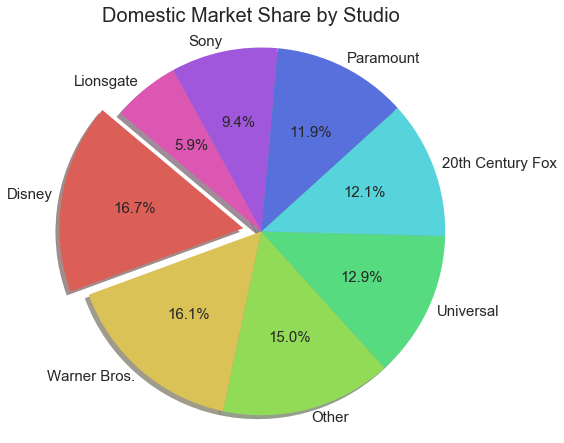

In [32]:
domestic_by_studio = studio_df.groupby("Studio")["Domestic Gross ($m)"].sum().sort_values(ascending=False)
plt.figure(figsize=(7.5,7.5))
patches, texts, autotexts = plt.pie(domestic_by_studio, labels=domestic_by_studio.index, explode=(0.1,0,0,0,0,0,0,0), 
                                    colors=sns.color_palette("hls", 8), autopct="%1.1f%%", shadow=True, labeldistance=1.05, 
                                    startangle=140)
plt.title("Domestic Market Share by Studio", size=20)
for text in texts:
    text.set_fontsize(15)
for autotext in autotexts:
    autotext.set_fontsize(15)
plt.axis("equal")
#plt.savefig("Plot3.1", bbox_inches="tight")
plt.show()

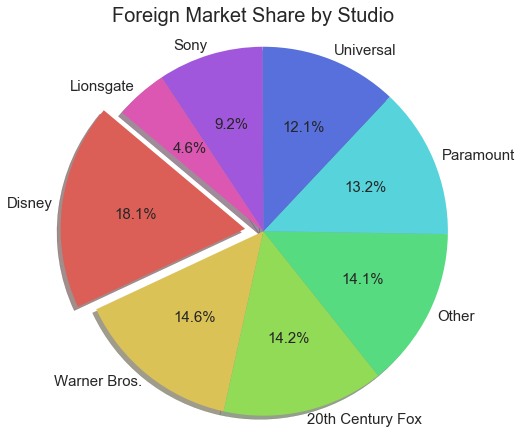

In [33]:
foreign_by_studio = studio_df.groupby("Studio")["Foreign Gross ($m)"].sum().sort_values(ascending=False)
plt.figure(figsize=(7.5,7.5))
patches, texts, autotexts = plt.pie(foreign_by_studio, labels=foreign_by_studio.index, explode=(0.1,0,0,0,0,0,0,0), 
                                    colors=sns.color_palette("hls", 8), autopct="%1.1f%%", shadow=True, labeldistance=1.05,
                                    startangle=140)
plt.title("Foreign Market Share by Studio", size=20)
for text in texts:
    text.set_fontsize(15)
for autotext in autotexts:
    autotext.set_fontsize(15)
plt.axis("equal")
#plt.savefig("Plot3.2", bbox_inches="tight")
plt.show()

## Budget vs. worldwide box office vs. MPAA rating

In [37]:
rated_df = df[["Movie", "Budget ($m)", "Worldwide Gross ($m)"]].copy()
rated_df["Rated"] = [responses[_]["Rated"] for _ in range(len(responses))]

In [38]:
rated_df["Rated"].value_counts()

PG-13        220
R            137
PG            96
G             11
N/A            5
NOT RATED      3
TV-14          2
TV-G           1
Name: Rated, dtype: int64

In [42]:
rated_df = rated_df[(rated_df["Rated"] != "N/A") & (rated_df["Rated"] != "NOT RATED") & 
                    (rated_df["Rated"] != "TV-14") & (rated_df["Rated"] != "TV-G")]
rated_df.head()

,Movie,Budget ($m),Worldwide Gross ($m),Rated
0,Jurassic World,215.0,1670.328025,PG-13
1,The Avengers,225.0,1519.479547,PG-13
2,Furious 7,190.0,1514.019071,PG-13
3,Harry Potter and the Deathly Hallows: Part II,125.0,1341.511219,PG-13
4,Frozen,150.0,1274.234980,PG


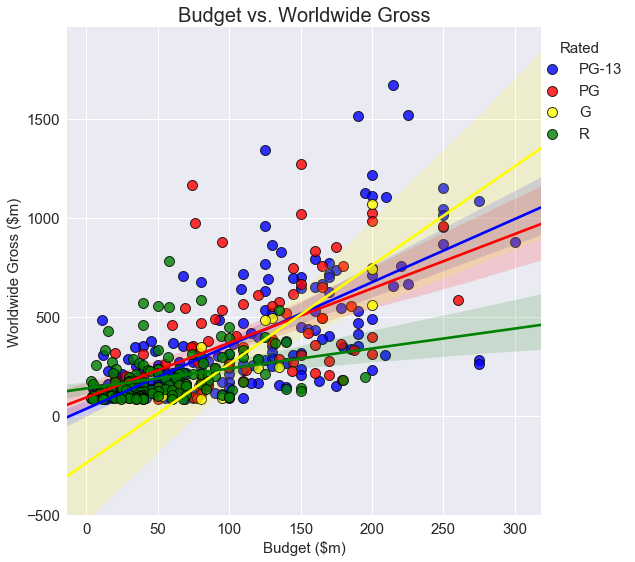

In [46]:
rated = set(rated_df["Rated"])
colors = ["r","yellow","b","g"]
sns.lmplot(x="Budget ($m)", y="Worldwide Gross ($m)", data=rated_df, hue="Rated", palette={i:j for i,j in zip(rated,colors)}, 
           scatter_kws={"alpha": .8, "s": 100, "lw": 1, "edgecolors": "k"}, size=7.5, aspect=1, legend=False)
plt.title("Budget vs. Worldwide Gross", size=20)
plt.xlabel("Budget ($m)", size=15)
plt.ylabel("Worldwide Gross ($m)", size=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.ylim(ymin=-500)
lgd = plt.legend(fontsize=15, bbox_to_anchor=(1.2, 1))
lgd.set_title("Rated", prop={"size": 15})
#plt.savefig("Plot4", bbox_inches="tight")
plt.show()